### **2025 SDSU Data Science Symposium**

**Date of Session:** February 6, 2025

**Instructor(s):** Cameron Pykiet, Jaylin Dyson, Bishnu Sarker

**Affiliation:** Meharry Medical College School of Applied Computational Sciences, Tennessee, USA

#  Case Study: Protein Function Prediction & Streamlit Interface

### Protein Function Prediction

Protein Function prediction is a popular computational biology problem in which one is given a protein sequence and needs to be able to determine its function, or Gene Ontology. Traditionaly this is a long manual process of making comparisons to known protein functions and relating it to the unknown one. However, as the database grows with protein sequences with unknown functions, our need for automatic functional annotation grows as well. 

For this case study, we will go over building a model for automatic function annotation prediction and create a streamlit interface for this model.

To save time, we will use pre-generated embeddings via uniprot: https://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/embeddings/uniprot_sprot/per-protein.h5 



In [6]:
# Load the Data ('Seq_class.csv')

# import necessary packages

import pandas as pd

seq_data = pd.read_csv('Seq_class.csv')
#data overview
seq_data.head()

,structureId,sequence,classification
0,177L,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,HYDROLASE
1,178L,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,HYDROLASE
2,1A0I,VNIKTNPFKAVSFVESAIKKALDNAGYLIAEIKYDGVRGNICVDNT...,LIGASE
3,1A16,SEISRQEFQRRRQALVEQMQPGSAALIFAAPEVTRSADSEYPYRQN...,HYDROLASE/HYDROLASE INHIBITOR
4,1A17,RDEPPADGALKRAEELKTQANDYFKAKDYENAIKFYSQAIELNPSN...,HYDROLASE


In [7]:
# Separate data columns for uses

seqs = list(seq_data.sequence) # all of the sequences in a list
data_labels = list(seq_data.classification) # all of the sequence classifications listed
labels = list(set(data_labels)) # Gets list of unique classifications
n_labels = len(labels)

In [4]:
len(seqs)

37951

In [5]:
# Get dataset with the embeddings ('case_study_1.pkl')

embedding_df = pd.read_pickle('case_study_1.pkl')
embedding_df.head()

,pdbId,uniprotId,sequence,embedding,classification
0,177L,P00720,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,"[0.0357, -0.02739, 0.06226, 0.0241, 0.048, -0....",HYDROLASE
1,178L,P00720,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,"[0.0357, -0.02739, 0.06226, 0.0241, 0.048, -0....",HYDROLASE
2,1A0I,P00969,VNIKTNPFKAVSFVESAIKKALDNAGYLIAEIKYDGVRGNICVDNT...,"[0.05447, -0.0781, -0.01279, 0.002829, -0.0485...",LIGASE
3,1A16,P15034,SEISRQEFQRRRQALVEQMQPGSAALIFAAPEVTRSADSEYPYRQN...,"[0.08923, 0.10504, 0.01293, 0.02536, 0.002459,...",HYDROLASE/HYDROLASE INHIBITOR
4,1A17,P53041,RDEPPADGALKRAEELKTQANDYFKAKDYENAIKFYSQAIELNPSN...,"[0.0579, 0.1092, 0.0112, 0.02176, 0.0195, 0.02...",HYDROLASE


In [6]:
len(embedding_df)

29824

The embedding_df is smaller than the prior dataset due to pre-processing that cleaned the dataset, aligned IDs, and formatted data accordingly. This shrinkage came from some of the IDs not having mappings or embeddings. 

In [7]:
X = list(embedding_df.embedding)
Y = list(embedding_df.classification)

labels = list(set(Y))
len(labels)

25

Plot showing the distribution of classes

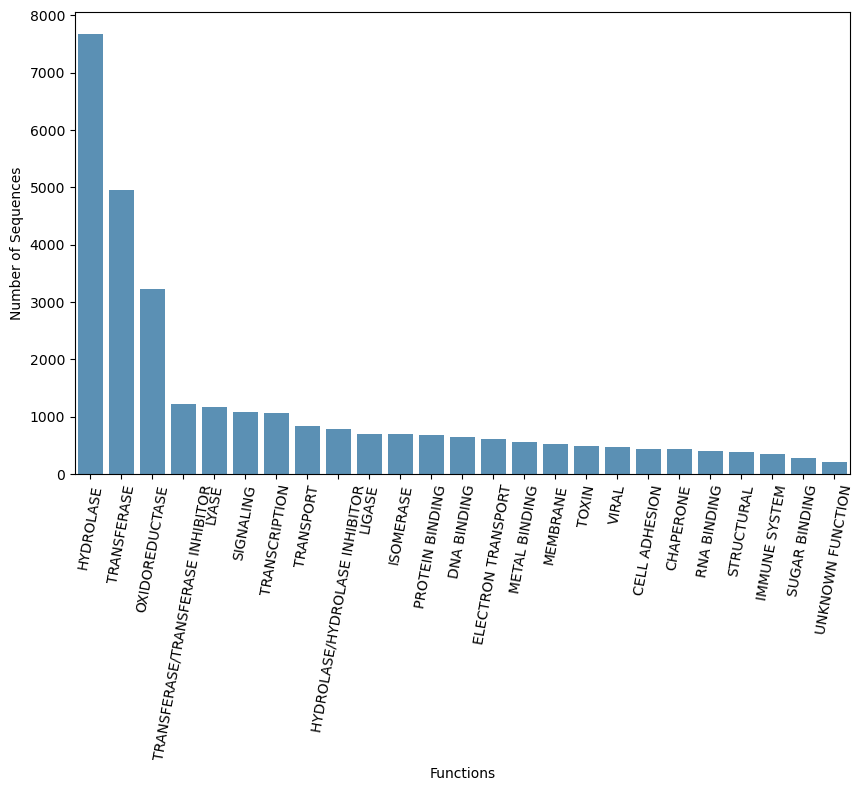

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

counts = embedding_df['classification'].value_counts()

plt.figure(figsize = (10,6))
sns.barplot(x = counts.index, y = counts.values, alpha = .8)

plt.ylabel('Number of Sequences')
plt.xlabel('Functions')
plt.xticks(rotation=80)
plt.show()

### Building a Model with sklearn

In [9]:
# import packages
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [10]:
# Split the data embedding_df
# X is Sequence embeddings
# y is functions / classifications
# stratify makes sure that each function gets split 80/20

x_train, x_test, y_train, y_test=train_test_split(X,Y, test_size=0.2, random_state=62, stratify=Y)

In [11]:
# Building a Logistic regression model with the embeddings
pfp_model=LogisticRegression(penalty='l2', max_iter=300)

In [12]:
pfp_model.fit(x_train,y_train)

LogisticRegression(max_iter=300)

In [27]:
import pickle

with open("pfp_model.pkl", "wb") as file:
    pickle.dump(pfp_model, file)

In [13]:
# Classification report
cr = classification_report(pfp_model.predict(x_test),y_test)

In [14]:
print(cr)

                                   precision    recall  f1-score   support

                    CELL ADHESION       0.51      0.56      0.53        78
                        CHAPERONE       0.75      0.83      0.79        77
                      DNA BINDING       0.58      0.75      0.66       101
               ELECTRON TRANSPORT       0.88      0.84      0.86       127
                        HYDROLASE       0.92      0.79      0.85      1780
    HYDROLASE/HYDROLASE INHIBITOR       0.03      0.80      0.05         5
                    IMMUNE SYSTEM       0.60      0.68      0.64        62
                        ISOMERASE       0.65      0.88      0.75       102
                           LIGASE       0.69      0.91      0.78       106
                            LYASE       0.76      0.84      0.80       213
                         MEMBRANE       0.55      0.54      0.54       108
                    METAL BINDING       0.45      0.72      0.55        69
                   OXIDO

In [15]:
m=confusion_matrix(y_test, pfp_model.predict(x_test))

In [16]:
import matplotlib.ticker as ticker


def plot_confusion(confusion_mat, unique_labels):

  fig=plt.figure()
  ax=fig.add_subplot(111)
  cax=ax.matshow(confusion_mat)
  fig.colorbar(cax)

  ax.set_xticklabels(['']+unique_labels, rotation=90)
  ax.set_yticklabels(['']+unique_labels)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

/var/folders/jx/mv25cpyn5j139zcblz3nlv8m0000gn/T/ipykernel_2629/608640289.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['']+unique_labels, rotation=90)
/var/folders/jx/mv25cpyn5j139zcblz3nlv8m0000gn/T/ipykernel_2629/608640289.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['']+unique_labels)


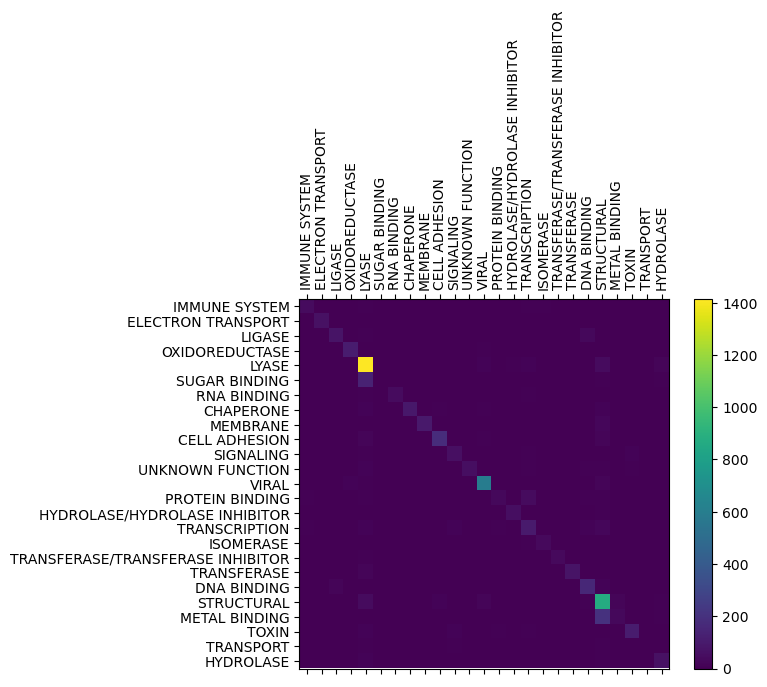

In [17]:
plot_confusion(m, unique_labels=labels)

In [16]:
x_test

[array([ 0.02643 , -0.0737  ,  0.0181  , ..., -0.005646,  0.01636 ,
         0.00563 ], dtype=float16),
 array([ 0.03174,  0.03354,  0.02179, ..., -0.03912,  0.02376,  0.04068],
       dtype=float16),
 array([ 0.007294,  0.0366  , -0.02327 , ...,  0.02979 , -0.0375  ,
         0.02298 ], dtype=float16),
 array([ 0.03036,  0.02391,  0.02286, ..., -0.03317,  0.02429,  0.04807],
       dtype=float16),
 array([-0.01721, -0.02612,  0.0825 , ..., -0.04492,  0.0503 ,  0.08575],
       dtype=float16),
 array([ 0.0076  ,  0.109   ,  0.008835, ...,  0.01556 , -0.02943 ,
         0.01178 ], dtype=float16),
 array([ 0.028  ,  0.02402,  0.01642, ..., -0.05484,  0.04538,  0.0462 ],
       dtype=float16),
 array([ 0.02563 , -0.02374 , -0.004036, ..., -0.00927 , -0.001553,
        -0.01535 ], dtype=float16),
 array([ 0.02682, -0.03525,  0.0827 , ..., -0.02011,  0.0756 ,  0.02864],
       dtype=float16),
 array([ 0.01198 ,  0.0768  ,  0.03827 , ..., -0.03604 , -0.06696 ,
         0.006237], dtype=float

Now that we have created our model for protein function annotation, we want to be able to use it universally for any protein sequence. However, to do this we have to use the same embedding technique as our training/test sets to allow our model to work correctly. Here we will have the tokenizer and model for getting our embeddings.

https://huggingface.co/Rostlab/prot_t5_xl_half_uniref50-enc

In [1]:
# Install needed packages
#!pip install torch transformers sentencepiece


In [2]:
import torch
from transformers import T5Tokenizer, T5EncoderModel

# Load ProtT5-XL tokenizer and model
model_name = "Rostlab/prot_t5_xl_half_uniref50-enc"
tokenizer = T5Tokenizer.from_pretrained(model_name, do_lower_case = False, legacy = False)
model = T5EncoderModel.from_pretrained(model_name)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [9]:
from random import sample


def prepare_data_dict(seqs, labels):
  data_dict={}
  for lbl, seq in zip(labels, seqs):
    if lbl not in data_dict:
      data_dict[lbl]=[seq]
    else:
      data_dict[lbl].append(seq)
  return data_dict


def prepare_examples(data_dict, unique_labels, sample_size=2):
  data_sample=[]
  lbls=[]

  for label in unique_labels:
    lbl=torch.tensor([unique_labels.index(label)], dtype=torch.long)
    seqs=sample(data_dict[label],sample_size)
    for seq in seqs:
      data_sample.append(seq)
      lbls.append(lbl)
  return data_sample, lbls

In [19]:
import re
def ProtT5_Embeddings(sequences):
  # to store the embeddings
  sequence_embeddings=[]
  # sequence to list of letter codes
  sequences=[" ".join(list(re.sub(r"[UZOB]", "X", sequence))) for sequence in sequences]
  # Generate indices
  ids = tokenizer.batch_encode_plus(sequences, add_special_tokens=True, padding="longest")

  input_ids = torch.tensor(ids['input_ids']).to(device)

  attention_mask = torch.tensor(ids['attention_mask']).to(device)


  with torch.no_grad():
      embedding_repr = model(input_ids=input_ids,attention_mask=attention_mask)

  # gather residue level embeddings for each sequence
  for i  in range(len(sequences)):
    embed=embedding_repr.last_hidden_state[i, :len(sequences[i])]
    embed_avg=embed.mean(dim=0) # average residue level emebddings to get sequence level embedding
    sequence_embeddings.append(embed_avg)
  return sequence_embeddings

This was code sourced via ***Bishnu Sarker, Sayane Shome (2024). Tutorial W18: Applying Generative Language Models for Biological Sequence Analysis. In AMIA Annual Symposium, NOV 9-13, San Francisco, USA.***

In [22]:
%%writefile pfp_app.py

import streamlit as st
import torch
from transformers import T5Tokenizer, T5EncoderModel
from random import sample
import re
import pickle
import pandas as pd

# Load ProtT5-XL tokenizer and model
model_name = "Rostlab/prot_t5_xl_half_uniref50-enc"
tokenizer = T5Tokenizer.from_pretrained(model_name, do_lower_case = False, legacy = False)
model = T5EncoderModel.from_pretrained(model_name)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')



def prepare_data_dict(seqs, labels):
  data_dict={}
  for lbl, seq in zip(labels, seqs):
    if lbl not in data_dict:
      data_dict[lbl]=[seq]
    else:
      data_dict[lbl].append(seq)
  return data_dict

def ProtT5_Embeddings(sequences):
  # to store the embeddings
  sequence_embeddings=[]
  # sequence to list of letter codes
  sequences=[" ".join(list(re.sub(r"[UZOB]", "X", sequence))) for sequence in sequences]
  # Generate indices
  ids = tokenizer.batch_encode_plus(sequences, add_special_tokens=True, padding="longest")

  input_ids = torch.tensor(ids['input_ids']).to(device)

  attention_mask = torch.tensor(ids['attention_mask']).to(device)


  with torch.no_grad():
      embedding_repr = model(input_ids=input_ids,attention_mask=attention_mask)

  # gather residue level embeddings for each sequence
  for i  in range(len(sequences)):
    embed=embedding_repr.last_hidden_state[i, :len(sequences[i])]
    embed_avg=embed.mean(dim=0) # average residue level emebddings to get sequence level embedding
    sequence_embeddings.append(embed_avg)
  return sequence_embeddings

with open("pfp_model.pkl", "rb") as file:
    loaded_model = pickle.load(file)
    
st.title('Protein Function Prediction Application')
st.caption('''
            This application takes a list of protein sequences, creates
            embeddings for the sequences using the ProtT5 embedding model
            and uses a trained Logistic Regression model to classify the 
            embeddings. There are 25 classes that can be chosen. This
            model may also take time to run. With that in mind, using 
            smaller files may be more optimal.
            ''')

col1, col2 = st.columns(2, gap = 'large')
col1.subheader('Input data here:')
col2.subheader('Output')
in_file = col1.file_uploader('CSV of Sequences', type = ['csv'])

if in_file:
    seq_df = pd.read_csv(in_file, index_col = 0)
    col1.dataframe(seq_df)
    
    seq_col = col2.selectbox('Choose column with sequences', list(seq_df.columns), index = None)
    
    if seq_col:
        gen = col2.button('Generate Predictions')
        
        if gen:
            preds = []
            sequences = list(seq_df[seq_col])
            embs = ProtT5_Embeddings(sequences)
            preds.append(loaded_model.predict(embs))
            col2.write(preds)
        
        


Overwriting pfp_app.py
